In [1]:
import pandas as pd
import numpy as np


In [2]:
train_m = pd.read_csv('train.csv')
test_m = pd.read_csv('test.csv')

In [3]:
train_m= train_m[['Id','cap.shape','cap.color','stalk.color.above.ring','stalk.color.below.ring','bruises','population','poisonous']]

#cap-shape: bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s
#cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r, pink=p,purple=u,red=e,white=w,yellow=y
#stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y
#stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y
#bruises-boolean
#population: abundant=a,clustered=c,numerous=n, scattered=s,several=v,solitary=y

In [4]:
train_m.isna().sum()

Id                        0
cap.shape                 0
cap.color                 0
stalk.color.above.ring    0
stalk.color.below.ring    0
bruises                   0
population                0
poisonous                 0
dtype: int64

In [10]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score

<h1>Decision tree</h1>

In [11]:
X = train_m.drop(columns=['poisonous'])
y = train_m['poisonous']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=8)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5524 entries, 1805 to 4547
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      5524 non-null   int64 
 1   cap.shape               5524 non-null   object
 2   cap.color               5524 non-null   object
 3   stalk.color.above.ring  5524 non-null   object
 4   stalk.color.below.ring  5524 non-null   object
 5   bruises                 5524 non-null   bool  
 6   population              5524 non-null   object
dtypes: bool(1), int64(1), object(5)
memory usage: 307.5+ KB


In [13]:
cat_col=list(X_train.select_dtypes(include=['object']))

In [14]:


categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ordinal',OneHotEncoder(handle_unknown='ignore'))
])
full_processor = ColumnTransformer(transformers=[
    ('category', categorical_pipeline, cat_col)
])

tree_pipeline = Pipeline(steps=[
    ('preprocess', full_processor), 
    ('model', DecisionTreeClassifier())])

pd.DataFrame(full_processor.fit_transform(X_train))
tree_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('category',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['cap.shape', 'cap.color',
                                                   'stalk.color.above.ring',
                                                   'stalk.color.below.ring',
                                                   'population'])])),
                ('model', DecisionTreeClassifier())])

In [15]:
accuracy_score(tree_pipeline.predict(X_train), y_train)

0.9060463432295438

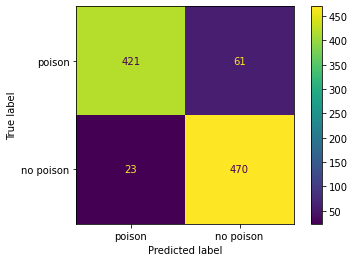

In [16]:
plot_confusion_matrix(tree_pipeline, X_test, y_test, display_labels=['poison', 'no poison'])

In [17]:
from sklearn.metrics import confusion_matrix

Accuracy:  0.9138461538461539


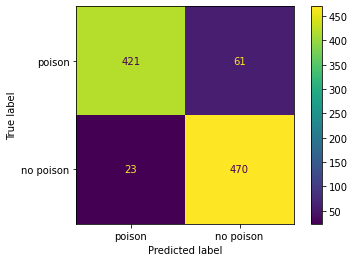

In [18]:
def model_check(y_true, y_preds, model):     
    print('Accuracy: ', accuracy_score(y_true, y_preds))
    classes = model.named_steps['model'].classes_    
    tn, fp, fn, tp = confusion_matrix(y_true, y_preds).ravel()
    plot_confusion_matrix(tree_pipeline, X_test, y_test, display_labels=['poison', 'no poison']);
    return tn, fp, fn, tp
tn, fp, fn, tp = model_check(y_test, tree_pipeline.predict(X_test), tree_pipeline)

In [19]:
from sklearn.metrics import precision_score, recall_score, cohen_kappa_score, f1_score
print(f"""
    Accuracy: {accuracy_score(tree_pipeline.predict(X_test), y_test)}
    Recall/Sensitivity: {recall_score(tree_pipeline.predict(X_test), y_test)}
    Precision (True Positive Rate): {precision_score(tree_pipeline.predict(X_test), y_test)}
    Specifity (False Positive Rate): {tn / (tn+fp)}
    F Score: {f1_score(tree_pipeline.predict(X_test), y_test)}
    Kappa: {cohen_kappa_score(tree_pipeline.predict(X_test), y_test)}
""")


    Accuracy: 0.9138461538461539
    Recall/Sensitivity: 0.8851224105461394
    Precision (True Positive Rate): 0.9533468559837728
    Specifity (False Positive Rate): 0.8734439834024896
    F Score: 0.9179687499999999
    Kappa: 0.8275186696824575



In [20]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

In [21]:
y_score= tree_pipeline.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

In [22]:
 threshold

array([2.        , 1.        , 0.91304348, 0.90909091, 0.85714286,
       0.85      , 0.84482759, 0.84210526, 0.83050847, 0.83018868,
       0.828125  , 0.82758621, 0.8255814 , 0.81355932, 0.80357143,
       0.79661017, 0.78688525, 0.77777778, 0.77419355, 0.76056338,
       0.74509804, 0.73239437, 0.65454545, 0.58227848, 0.57692308,
       0.54545455, 0.54166667, 0.52      , 0.45714286, 0.41040462,
       0.38461538, 0.3220339 , 0.3       , 0.29411765, 0.2       ,
       0.        ])

In [346]:
dt=  roc_auc_score(y_test, y_score)
dt

0.9650669539528502

In [23]:
print('roc_auc_score for DecisionTree: ', roc_auc_score(y_test, y_score))

roc_auc_score for DecisionTree:  0.9650669539528502


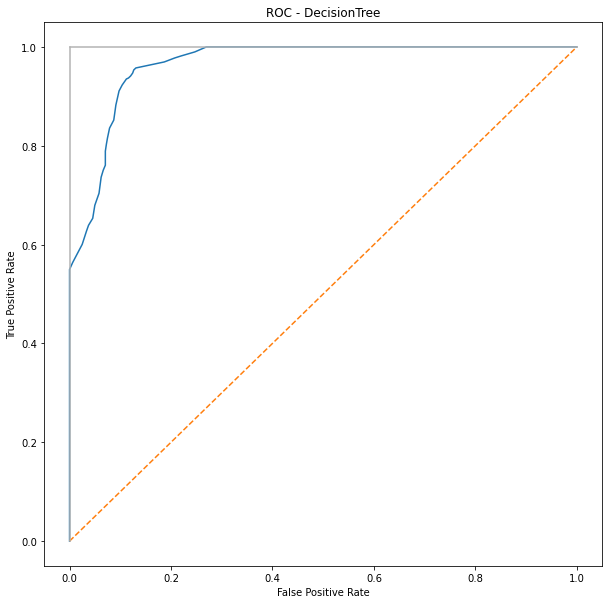

In [24]:
plt.subplots(1, figsize=(10,10))
plt.title('ROC - DecisionTree')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<h1>Decrease False Negative</h1>

In [25]:
train_m = pd.read_csv('train.csv')
train_m= train_m[['Id','cap.shape','cap.color','stalk.color.above.ring','stalk.color.below.ring','bruises','population','poisonous']]

X = train_m.drop(columns=['poisonous'])
y = train_m['poisonous']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=8)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [26]:
cat_col=list(X_train.select_dtypes(include=['object']))

In [27]:
categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ordinal',OneHotEncoder(handle_unknown='ignore'))
])
full_processor = ColumnTransformer(transformers=[
    ('category', categorical_pipeline, cat_col)
])

tree_pipeline = Pipeline(steps=[
    ('preprocess', full_processor), 
    ('model', DecisionTreeClassifier())])

pd.DataFrame(full_processor.fit_transform(X_train))
tree_pipeline.fit(X_train, y_train)
THRESHOLD= 0.45714286
preds = np.where(tree_pipeline.predict_proba(X_test)[:,1] >= THRESHOLD, 1, 0)

In [28]:
preds

array([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,

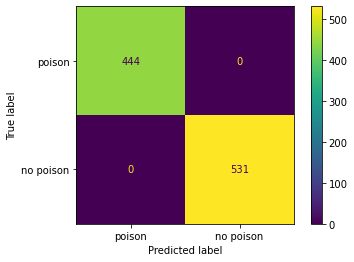

In [29]:
plot_confusion_matrix(tree_pipeline, X_test, preds, display_labels=['poison', 'no poison'])

<h1>Logistic regression</h1>

In [30]:
train_m = pd.read_csv('train.csv')
train_m= train_m[['Id','cap.shape','cap.color','stalk.color.above.ring','stalk.color.below.ring','bruises','population','poisonous']]
train_m

,Id,cap.shape,cap.color,stalk.color.above.ring,stalk.color.below.ring,bruises,population,poisonous
0,6573,k,e,w,w,False,v,1
1,4426,f,e,p,w,True,y,0
2,7018,b,w,w,w,False,s,0
3,5789,k,g,w,w,False,n,0
4,6187,f,n,p,g,True,v,0
...,...,...,...,...,...,...,...,...
6494,7002,f,g,b,b,False,v,1
6495,7323,k,e,p,p,False,v,1
6496,6206,f,g,n,b,False,y,1
6497,4658,f,n,w,w,True,s,0


In [31]:
X = train_m.drop(columns=['poisonous'])
y = train_m['poisonous']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=8)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [32]:
logreg = LogisticRegression()

In [33]:

cat_col=list(X_train.select_dtypes(include=['object']))

In [34]:

categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ordinal',OneHotEncoder(handle_unknown='ignore'))
])
full_processor = ColumnTransformer(transformers=[
    ('category', categorical_pipeline, cat_col)
])

logreg_pipeline = Pipeline(steps=[
    ('preprocess', full_processor), 
    ('model',  LogisticRegression())])

pd.DataFrame(full_processor.fit_transform(X_train))
logreg_pipeline.fit(X_train, y_train)

/Users/sabrinamarano/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('category',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['cap.shape', 'cap.color',
                                                   'stalk.color.above.ring',
                                                   'stalk.color.below.ring',
                                                   'population'])])),
                ('model', LogisticRegression())])

In [35]:
accuracy_score(logreg_pipeline.predict(X_train), y_train)

0.8718320057929037

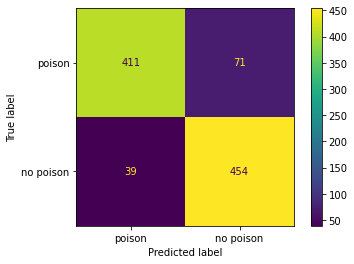

In [36]:
plot_confusion_matrix(logreg_pipeline, X_test, y_test, display_labels=['poison', 'no poison']);

In [37]:
print(f"""
    Accuracy: {accuracy_score(logreg_pipeline.predict(X_test), y_test)}
    Recall/Sensitivity: {recall_score(logreg_pipeline.predict(X_test), y_test)}
    Precision (True Positive Rate): {precision_score(logreg_pipeline.predict(X_test), y_test)}
    Specifity (False Positive Rate): {tn / (tn+fp)}
    F Score: {f1_score(logreg_pipeline.predict(X_test), y_test)}
    Kappa: {cohen_kappa_score(logreg_pipeline.predict(X_test), y_test)}
""")


    Accuracy: 0.8871794871794871
    Recall/Sensitivity: 0.8647619047619047
    Precision (True Positive Rate): 0.920892494929006
    Specifity (False Positive Rate): 0.8734439834024896
    F Score: 0.8919449901768173
    Kappa: 0.7741629816803538



In [38]:
y_score1= logreg_pipeline.predict_proba(X_test)[:,1]
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)

In [44]:
threshold1

array([1.99990078, 0.99990078, 0.99989909, 0.999877  , 0.99987491,
       0.99964662, 0.99964062, 0.99956196, 0.99872698, 0.99870537,
       0.99860119, 0.99857744, 0.99842232, 0.99839554, 0.99826647,
       0.99823705, 0.99596466, 0.99589634, 0.9954797 , 0.9954032 ,
       0.99503461, 0.99491769, 0.99440225, 0.99430762, 0.99385173,
       0.98999011, 0.98604047, 0.98597916, 0.98275208, 0.98232463,
       0.98202953, 0.97890675, 0.97856194, 0.97818029, 0.97781756,
       0.9725151 , 0.96651127, 0.95943252, 0.95220486, 0.95143175,
       0.94973065, 0.94828951, 0.94589893, 0.94502971, 0.93976098,
       0.93939005, 0.93842306, 0.93534952, 0.93378952, 0.93273957,
       0.93271722, 0.92638464, 0.92522667, 0.91815573, 0.90471883,
       0.89588919, 0.89430625, 0.88042027, 0.88021175, 0.87376695,
       0.87189576, 0.86966327, 0.86774046, 0.86240236, 0.86038963,
       0.85312719, 0.84831058, 0.8461285 , 0.84036018, 0.83808555,
       0.83486666, 0.83252935, 0.8183139 , 0.81603082, 0.80321

In [43]:
np.set_printoptions(suppress=True)

In [40]:
lr=roc_auc_score(y_test, y_score1)
lr

0.9448082280558524

In [41]:
print('roc_auc_score for LogisticRegression: ', roc_auc_score(y_test, y_score1))

roc_auc_score for LogisticRegression:  0.9448082280558524


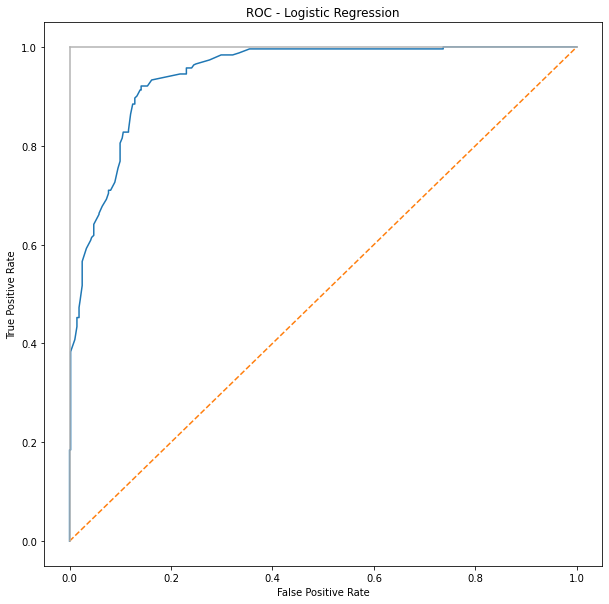

In [42]:
plt.subplots(1, figsize=(10,10))
plt.title('ROC - Logistic Regression')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<h1>Decrease False Negative Logistic Regression</h1>

In [45]:
train_m = pd.read_csv('train.csv')
train_m= train_m[['Id','cap.shape','cap.color','stalk.color.above.ring','stalk.color.below.ring','bruises','population','poisonous']]

X = train_m.drop(columns=['poisonous'])
y = train_m['poisonous']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=8)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [46]:
logreg = LogisticRegression()

In [47]:
cat_col=list(X_train.select_dtypes(include=['object']))

In [48]:

categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ordinal',OneHotEncoder(handle_unknown='ignore'))
])
full_processor = ColumnTransformer(transformers=[
    ('category', categorical_pipeline, cat_col)
])

logreg_pipeline = Pipeline(steps=[
    ('preprocess', full_processor), 
    ('model',  LogisticRegression())])

pd.DataFrame(full_processor.fit_transform(X_train))
logreg_pipeline.fit(X_train, y_train)
THRESHOLD=  0.35366377
preds = np.where(logreg_pipeline.predict_proba(X_test)[:,1] >= THRESHOLD, 1, 0)

/Users/sabrinamarano/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


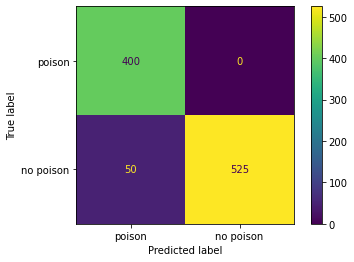

In [49]:
plot_confusion_matrix(logreg_pipeline, X_test, preds, display_labels=['poison', 'no poison'])

<h1>Support Vector machine</h1>

In [52]:
train_m = pd.read_csv('train.csv')
train_m= train_m[['Id','cap.shape','cap.color','stalk.color.above.ring','stalk.color.below.ring','bruises','population','poisonous']]
X = train_m.drop(columns=['poisonous'])
y = train_m['poisonous']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=8)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [53]:
svc = SVC(C=1.0, random_state=8, kernel='linear', probability=True)

In [54]:

cat_col=list(X_train.select_dtypes(include=['object']))

In [55]:


categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ordinal',OneHotEncoder(handle_unknown='ignore'))
])
full_processor = ColumnTransformer(transformers=[
  
    ('category', categorical_pipeline, cat_col)
])

svc = Pipeline(steps=[
    ('preprocess', full_processor), 
    ('model',  SVC(C=1.0, random_state=8, kernel='linear', probability=True))])

pd.DataFrame(full_processor.fit_transform(X_train))

,0
0,"(0, 1)\t1.0\n (0, 9)\t1.0\n (0, 22)\t1.0\n..."
1,"(0, 1)\t1.0\n (0, 7)\t1.0\n (0, 21)\t1.0\n..."
2,"(0, 1)\t1.0\n (0, 9)\t1.0\n (0, 20)\t1.0\n..."
3,"(0, 4)\t1.0\n (0, 8)\t1.0\n (0, 22)\t1.0\n..."
4,"(0, 4)\t1.0\n (0, 9)\t1.0\n (0, 22)\t1.0\n..."
...,...
5519,"(0, 2)\t1.0\n (0, 9)\t1.0\n (0, 21)\t1.0\n..."
5520,"(0, 4)\t1.0\n (0, 14)\t1.0\n (0, 19)\t1.0\..."
5521,"(0, 4)\t1.0\n (0, 8)\t1.0\n (0, 21)\t1.0\n..."
5522,"(0, 4)\t1.0\n (0, 9)\t1.0\n (0, 22)\t1.0\n..."


In [56]:
svc.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('category',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['cap.shape', 'cap.color',
                                                   'stalk.color.above.ring',
                                                   'stalk.color.below.ring',
                                                   'population'])])),
                ('model',
                 SVC(kernel='linear', probability=True, random_state=8))])

In [57]:
accuracy_score(svc.predict(X_train), y_train)

0.8772628530050688

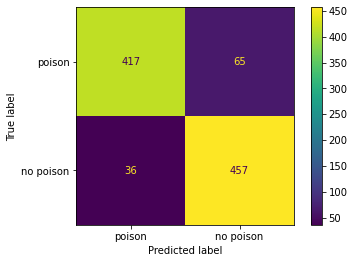

In [58]:
plot_confusion_matrix(svc, X_test, y_test, display_labels=['poison', 'no poison']);

In [59]:
print(f"""
    Accuracy: {accuracy_score(svc.predict(X_test), y_test)}
    Recall/Sensitivity: {recall_score(svc.predict(X_test), y_test)}
    Precision (True Positive Rate): {precision_score(svc.predict(X_test), y_test)}
    Specifity (False Positive Rate): {tn / (tn+fp)}
    F Score: {f1_score(svc.predict(X_test), y_test)}
    Kappa: {cohen_kappa_score(svc.predict(X_test), y_test)}
""")


    Accuracy: 0.8964102564102564
    Recall/Sensitivity: 0.8754789272030651
    Precision (True Positive Rate): 0.9269776876267748
    Specifity (False Positive Rate): 0.8734439834024896
    F Score: 0.9004926108374384
    Kappa: 0.792654963963338



In [60]:
y_score2= svc.predict_proba(X_test)[:,1]
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)

In [61]:
threshold2

array([1.99999935, 0.99999935, 0.99999935, 0.99999935, 0.99999935,
       0.99999935, 0.99999935, 0.99999935, 0.99999935, 0.99999935,
       0.99999935, 0.99999935, 0.99999935, 0.99999935, 0.99999935,
       0.99999935, 0.98914274, 0.98914163, 0.98913995, 0.98913931,
       0.9891386 , 0.989138  , 0.98913771, 0.98913758, 0.9891375 ,
       0.98913703, 0.9891366 , 0.98913647, 0.98913646, 0.98913633,
       0.98913608, 0.98913582, 0.98913566, 0.98913535, 0.98913522,
       0.98913479, 0.98913455, 0.98913357, 0.98913344, 0.98913342,
       0.98913316, 0.9891326 , 0.98913246, 0.98913234, 0.98913189,
       0.98913176, 0.98913079, 0.98913066, 0.98913033, 0.98912741,
       0.79442003, 0.79441144, 0.7944092 , 0.79440493, 0.7944032 ,
       0.79439461, 0.79438986, 0.7943881 , 0.79438775, 0.79438751,
       0.79438593, 0.79437941, 0.79437903, 0.79437692, 0.79437669,
       0.79437302, 0.79437092, 0.79437068, 0.7943691 , 0.79436586,
       0.79436258, 0.7943617 , 0.79435986, 0.79435804, 0.79435

In [62]:
svm=roc_auc_score(y_test, y_score2)

In [63]:
print('roc_auc_score for Support Vector Machine: ', roc_auc_score(y_test, y_score2))

roc_auc_score for Support Vector Machine:  0.9329155900448604


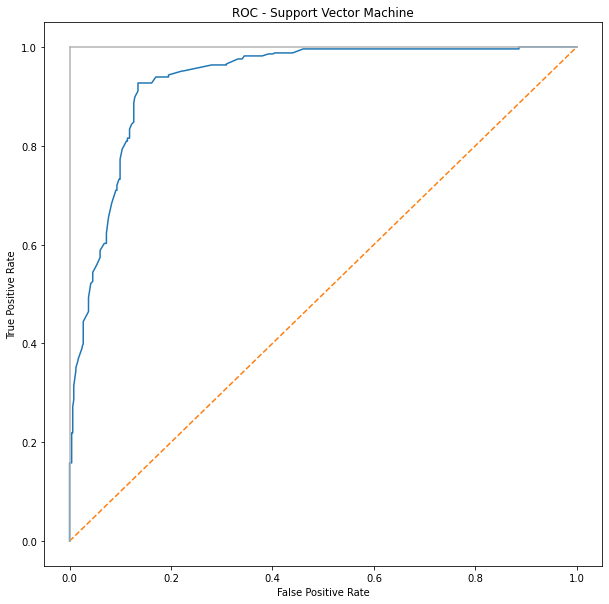

In [64]:
plt.subplots(1, figsize=(10,10))
plt.title('ROC - Support Vector Machine')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<h1>Decrease False Negative SVM</h1>

In [65]:
train_m = pd.read_csv('train.csv')
train_m= train_m[['Id','cap.shape','cap.color','stalk.color.above.ring','stalk.color.below.ring','bruises','population','poisonous']]
X = train_m.drop(columns=['poisonous'])
y = train_m['poisonous']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=8)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [66]:
svc = SVC(C=1.0, random_state=8, kernel='linear', probability=True)

In [67]:

cat_col=list(X_train.select_dtypes(include=['object']))

In [101]:

categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ordinal',OneHotEncoder(handle_unknown='ignore'))
])
full_processor = ColumnTransformer(transformers=[
  
    ('category', categorical_pipeline, cat_col)
])

svc = Pipeline(steps=[
    ('preprocess', full_processor), 
    ('model',  SVC(C=1.0, random_state=8, kernel='linear', probability=True))])

pd.DataFrame(full_processor.fit_transform(X_train))
svc.fit(X_train, y_train)
THRESHOLD= 0.14081378
preds = np.where(svc.predict_proba(X_test)[:,1] >= THRESHOLD, 1, 0)

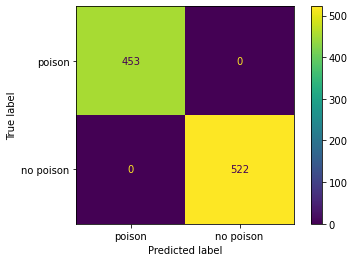

In [102]:
plot_confusion_matrix(svc, X_test, preds, display_labels=['poison', 'no poison'])

<h1>Robust Random Forest</h1>

In [72]:
from sklearn.ensemble import RandomForestClassifier

In [73]:
train_m = pd.read_csv('train.csv')
train_m= train_m[['Id','cap.shape','cap.color','stalk.color.above.ring','stalk.color.below.ring','bruises','population','poisonous']]
X = train_m.drop(columns=['poisonous'])
y = train_m['poisonous']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=8)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [74]:
rf = RandomForestClassifier(max_depth=2, random_state=8)

In [75]:

cat_col=list(X_train.select_dtypes(include=['object']))

In [76]:


categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ordinal',OneHotEncoder(handle_unknown='ignore'))
])
full_processor = ColumnTransformer(transformers=[ 
    ('category', categorical_pipeline, cat_col)
])

random_pipeline = Pipeline(steps=[
    ('preprocess', full_processor), 
    ('model',  RandomForestClassifier(max_depth=2, random_state=8))])

pd.DataFrame(full_processor.fit_transform(X_train))

,0
0,"(0, 1)\t1.0\n (0, 9)\t1.0\n (0, 22)\t1.0\n..."
1,"(0, 1)\t1.0\n (0, 7)\t1.0\n (0, 21)\t1.0\n..."
2,"(0, 1)\t1.0\n (0, 9)\t1.0\n (0, 20)\t1.0\n..."
3,"(0, 4)\t1.0\n (0, 8)\t1.0\n (0, 22)\t1.0\n..."
4,"(0, 4)\t1.0\n (0, 9)\t1.0\n (0, 22)\t1.0\n..."
...,...
5519,"(0, 2)\t1.0\n (0, 9)\t1.0\n (0, 21)\t1.0\n..."
5520,"(0, 4)\t1.0\n (0, 14)\t1.0\n (0, 19)\t1.0\..."
5521,"(0, 4)\t1.0\n (0, 8)\t1.0\n (0, 21)\t1.0\n..."
5522,"(0, 4)\t1.0\n (0, 9)\t1.0\n (0, 22)\t1.0\n..."


In [77]:
random_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('category',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['cap.shape', 'cap.color',
                                                   'stalk.color.above.ring',
                                                   'stalk.color.below.ring',
                                                   'population'])])),
                ('model', RandomForestClassifier(max_depth=2, random_state=8))])

In [78]:
accuracy_score(random_pipeline.predict(X_train), y_train)

0.8473931933381608

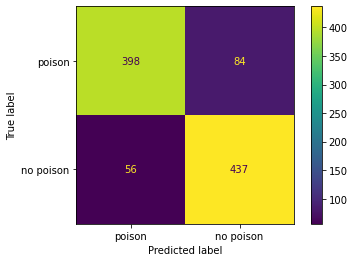

In [79]:
plot_confusion_matrix(random_pipeline, X_test, y_test, display_labels=['poison', 'no poison']);

In [80]:
print(f"""
    Accuracy: {accuracy_score(random_pipeline.predict(X_test), y_test)}
    Recall/Sensitivity: {recall_score(random_pipeline.predict(X_test), y_test)}
    Precision (True Positive Rate): {precision_score(random_pipeline.predict(X_test), y_test)}
    Specifity (False Positive Rate): {tn / (tn+fp)}
    F Score: {f1_score(random_pipeline.predict(X_test), y_test)}
    Kappa: {cohen_kappa_score(random_pipeline.predict(X_test), y_test)}
""")


    Accuracy: 0.8564102564102564
    Recall/Sensitivity: 0.8387715930902111
    Precision (True Positive Rate): 0.8864097363083164
    Specifity (False Positive Rate): 0.8734439834024896
    F Score: 0.8619329388560157
    Kappa: 0.7125976957283385



In [81]:
y_score3= random_pipeline.predict_proba(X_test)[:,1]
false_positive_rate3, true_positive_rate3, threshold3 = roc_curve(y_test, y_score3)

In [82]:
threshold3

array([1.73647921, 0.73647921, 0.73553919, 0.72754719, 0.72722066,
       0.72538968, 0.72444965, 0.71979272, 0.71653419, 0.71620766,
       0.70522379, 0.66939729, 0.66750703, 0.66724367, 0.65830776,
       0.65615414, 0.64975792, 0.64561715, 0.63793299, 0.63720798,
       0.63521282, 0.63427762, 0.63323522, 0.63154398, 0.62952167,
       0.62903959, 0.62787875, 0.62273941, 0.62212591, 0.61836001,
       0.61697504, 0.6163377 , 0.61495274, 0.61330982, 0.61007392,
       0.6008749 , 0.59724499, 0.59667927, 0.59219431, 0.59098072,
       0.58599968, 0.58461472, 0.58397738, 0.58259241, 0.58229793,
       0.58121565, 0.57964437, 0.57843078, 0.57718467, 0.57479287,
       0.56814947, 0.56491635, 0.56463473, 0.55991766, 0.55897763,
       0.55842012, 0.55746988, 0.55652986, 0.55306531, 0.55304303,
       0.55244294, 0.55212529, 0.54874169, 0.5481282 , 0.54520609,
       0.5447896 , 0.54183967, 0.53989256, 0.53565479, 0.53324915,
       0.52501734, 0.52407731, 0.52321577, 0.52256957, 0.52178

In [83]:
rf= roc_auc_score(y_test, y_score3)
rf

0.9013323457870771

In [84]:
print('roc_auc_score for DecisionTree: ', roc_auc_score(y_test, y_score3))

roc_auc_score for DecisionTree:  0.9013323457870771


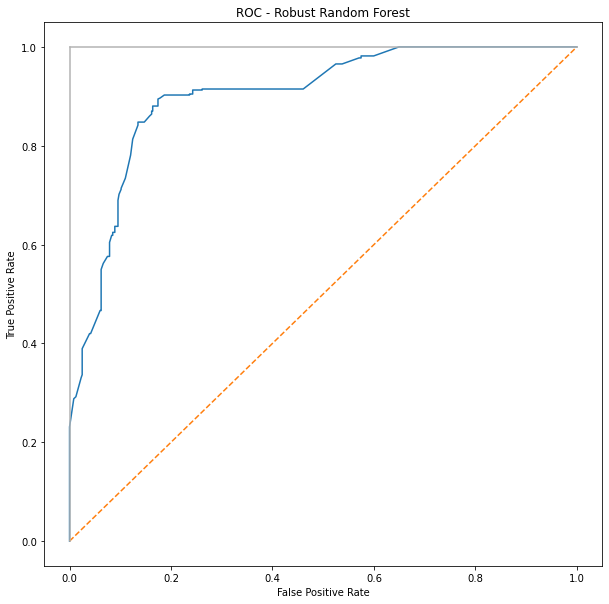

In [85]:
plt.subplots(1, figsize=(10,10))
plt.title('ROC - Robust Random Forest')
plt.plot(false_positive_rate3, true_positive_rate3)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<h1>Decrease False Negative Random Forest</h1>

In [86]:
train_m = pd.read_csv('train.csv')
train_m= train_m[['Id','cap.shape','cap.color','stalk.color.above.ring','stalk.color.below.ring','bruises','population','poisonous']]
X = train_m.drop(columns=['poisonous'])
y = train_m['poisonous']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=8)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [87]:
rf = RandomForestClassifier(max_depth=2, random_state=8)

In [88]:

cat_col=list(X_train.select_dtypes(include=['object']))

In [97]:

categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ordinal',OneHotEncoder(handle_unknown='ignore'))
])
full_processor = ColumnTransformer(transformers=[ 
    ('category', categorical_pipeline, cat_col)
])

random_pipeline = Pipeline(steps=[
    ('preprocess', full_processor), 
    ('model',  RandomForestClassifier(max_depth=2, random_state=8))])

pd.DataFrame(full_processor.fit_transform(X_train))
random_pipeline.fit(X_train, y_train)
THRESHOLD= 0.27055524
preds = np.where(random_pipeline.predict_proba(X_test)[:,1] >= THRESHOLD, 1, 0)

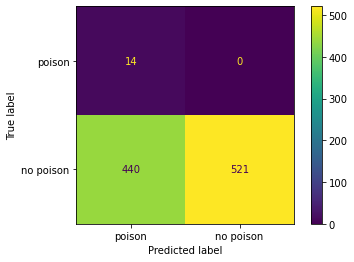

In [98]:
plot_confusion_matrix(random_pipeline, X_test, preds, display_labels=['poison', 'no poison']);

<h1>Let's plot together in order to choose</h1>

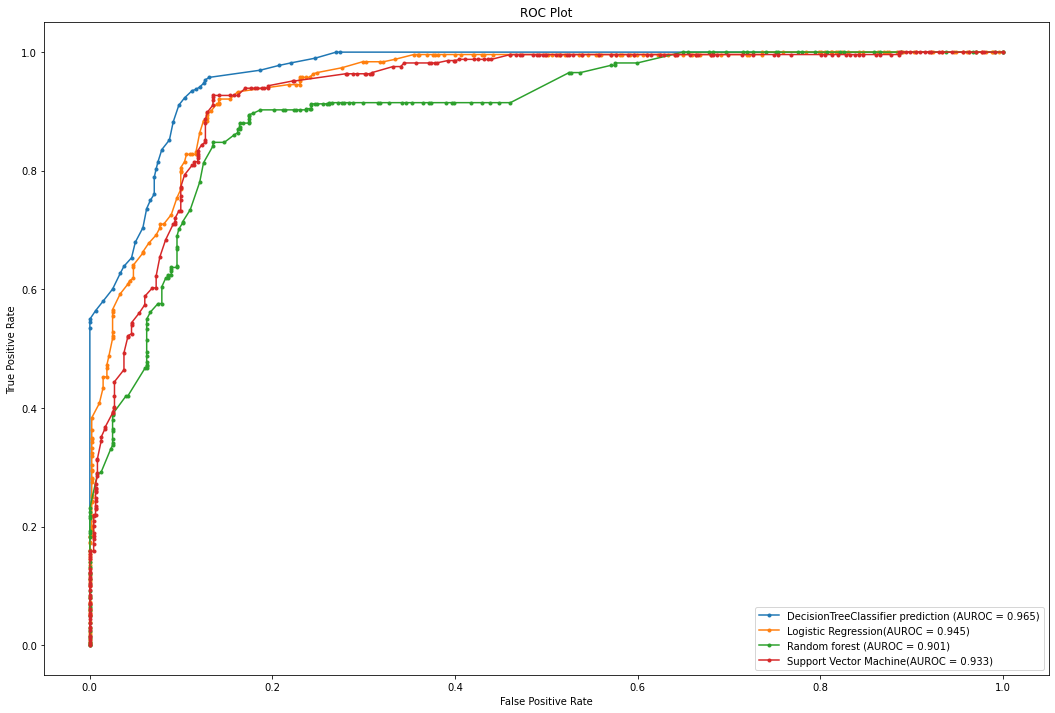

In [391]:
plt.figure(figsize=(18,12))
plt.plot(false_positive_rate, true_positive_rate, marker='.', label='DecisionTreeClassifier prediction (AUROC = %0.3f)' % dt)
plt.plot(false_positive_rate1, true_positive_rate1, marker='.', label='Logistic Regression(AUROC = %0.3f)' % lr)
plt.plot(false_positive_rate3, true_positive_rate3, marker='.', label='Random forest (AUROC = %0.3f)' % rf)
plt.plot(false_positive_rate2, true_positive_rate2, marker='.', label='Support Vector Machine(AUROC = %0.3f)' % svm)
plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend() 
plt.show()